## 1. Import Libriary

In [503]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2. Display Settings

In [505]:
pd.set_option("display.max_columns", None)

In [506]:
sklearn.set_config(transform_output="pandas")

In [507]:
warnings.filterwarnings("ignore")

## 3. Load the data set

In [509]:
path = r"C:\\Users\\Santosh Kumar_TSI\\AWS SageMaker flight price prediction\\train.csv"

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-03-06,Banglore,Delhi,08:00:00,08:15:00,1455,1,no info,17996
1,Spicejet,2019-06-06,Kolkata,Banglore,22:20:00,00:40:00,140,0,no info,3873
2,Indigo,2019-03-18,Kolkata,Banglore,05:30:00,08:20:00,170,0,no info,4462
3,Jet Airways,2019-03-24,Mumbai,Hyderabad,15:50:00,17:20:00,90,0,in-flight meal not included,2228
4,Spicejet,2019-04-27,Banglore,Delhi,09:30:00,12:20:00,170,0,no info,4991
...,...,...,...,...,...,...,...,...,...,...
7318,Jet Airways,2019-05-27,Delhi,Cochin,18:15:00,04:25:00,610,1,in-flight meal not included,12898
7319,Indigo,2019-05-18,Kolkata,Banglore,11:30:00,14:05:00,155,0,no info,4804
7320,Jet Airways,2019-05-18,Banglore,Delhi,11:10:00,14:05:00,175,0,no info,7229
7321,Air India,2019-06-09,Banglore,Delhi,13:20:00,16:10:00,170,0,no info,6961


## 3. Read the data

In [511]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7323 entries, 0 to 7322
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   airline          7323 non-null   object
 1   date_of_journey  7323 non-null   object
 2   source           7323 non-null   object
 3   destination      7323 non-null   object
 4   dep_time         7323 non-null   object
 5   arrival_time     7323 non-null   object
 6   duration         7323 non-null   int64 
 7   total_stops      7323 non-null   int64 
 8   additional_info  7323 non-null   object
 9   price            7323 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 572.2+ KB


## 4. Seperate the input columns  & target column

In [513]:
x= train.drop(columns="price")
x.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-03-06,Banglore,Delhi,08:00:00,08:15:00,1455,1,no info
1,Spicejet,2019-06-06,Kolkata,Banglore,22:20:00,00:40:00,140,0,no info
2,Indigo,2019-03-18,Kolkata,Banglore,05:30:00,08:20:00,170,0,no info
3,Jet Airways,2019-03-24,Mumbai,Hyderabad,15:50:00,17:20:00,90,0,in-flight meal not included
4,Spicejet,2019-04-27,Banglore,Delhi,09:30:00,12:20:00,170,0,no info


In [514]:
y= train.price
y.head()

0    17996
1     3873
2     4462
3     2228
4     4991
Name: price, dtype: int64

## 5. Transformation Operations

### **5.1 `airline`**

In [517]:
air_transform=Pipeline(steps=[("imputer", SimpleImputer(strategy= "most_frequent")),
         ("grouper",RareLabelEncoder(tol=.1,replace_with="others",n_categories=2)),
         ("encoder" , OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
          ])
air_transform.fit_transform(x.loc[:,["airline"]])

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_others
0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
7318,0.0,0.0,1.0,0.0,0.0
7319,0.0,1.0,0.0,0.0,0.0
7320,0.0,0.0,1.0,0.0,0.0
7321,1.0,0.0,0.0,0.0,0.0


### **5.2 `date_of_journey`**

In [519]:
feature_to_extract=["month", "week", "day_of_week", "day_of_year"]
dt_transform=Pipeline(steps=[("transform",DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
                            ("scale",MinMaxScaler())])
dt_transform.fit_transform(x.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.000000,0.058824,0.333333,0.042373
1,1.000000,0.823529,0.500000,0.822034
2,0.000000,0.176471,0.000000,0.144068
3,0.000000,0.176471,1.000000,0.194915
4,0.333333,0.470588,0.833333,0.483051
...,...,...,...,...
7318,0.666667,0.764706,0.000000,0.737288
7319,0.666667,0.647059,0.833333,0.661017
7320,0.666667,0.647059,0.833333,0.661017
7321,1.000000,0.823529,1.000000,0.847458


### 5.3 **`source` & `destination`**

In [521]:
route= x[["source","destination"]]
route_transform1= Pipeline(steps=[("grouper",RareLabelEncoder(tol=.1, replace_with="others",n_categories=2)),
                                 ("encoder" ,MeanEncoder()),
                                 ("power_transformer",PowerTransformer())
])
route_transform1.fit_transform(route,y)

,source,destination
0,-0.922802,-0.922802
1,-0.184486,-0.184486
2,-0.184486,-0.184486
3,-1.864612,-1.864612
4,-0.922802,-0.922802
...,...,...
7318,1.055474,1.055474
7319,-0.184486,-0.184486
7320,-0.922802,-0.922802
7321,-0.922802,-0.922802


In [522]:
np.union1d(x.source.unique(),x.destination.unique())

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai'], dtype=object)

In [523]:
def is_north(df):
    cities=['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
           'Mumbai']
    condition=np.isin(df[["source","destination"]],['Banglore', 'Chennai', 'Cochin', 'Hyderabad'])
    newdf=pd.DataFrame()
    newdf[["source_is_north","destination_is_north"]]=np.select([condition], [0], default=1)
    return newdf

is_north(route)
FunctionTransformer(func=is_north).fit_transform(route)

,source_is_north,destination_is_north
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
7318,1,0
7319,1,0
7320,0,1
7321,0,1


In [524]:
route_transformer = FeatureUnion(transformer_list=[
	("part1", route_transform1),
	("part2", FunctionTransformer(func=is_north))
])

route_transformer.fit_transform(route, y)

,source,destination,source_is_north,destination_is_north
0,-0.922802,-0.922802,0,1
1,-0.184486,-0.184486,1,0
2,-0.184486,-0.184486,1,0
3,-1.864612,-1.864612,1,0
4,-0.922802,-0.922802,0,1
...,...,...,...,...
7318,1.055474,1.055474,1,0
7319,-0.184486,-0.184486,1,0
7320,-0.922802,-0.922802,0,1
7321,-0.922802,-0.922802,0,1


### **5.4 `dep_time & arrival_time`**

In [526]:
import vizpro


In [527]:
x["dep_time"]=pd.to_datetime(x["dep_time"])
x["arrival_time"]=pd.to_datetime(x["arrival_time"])
time= x[["dep_time","arrival_time"]]

In [528]:
def time_foo(x):
    time_df = pd.DataFrame()
    time_df["dep_time_of_day"]=vizpro.assign_time_of_day(x,"dep_time")["time_of_day"]
    time_df["arrival_time_of_day"]=vizpro.assign_time_of_day(x,"arrival_time")["time_of_day"]
    return(time_df)
FunctionTransformer(func=time_foo).fit_transform(time)

,dep_time_of_day,arrival_time_of_day
0,morning,morning
1,night,night
2,morning,morning
3,afternoon,evening
4,morning,afternoon
...,...,...
7318,evening,morning
7319,morning,afternoon
7320,morning,afternoon
7321,afternoon,evening


In [529]:
time_transformer1= Pipeline(steps=[("part", FunctionTransformer(func=time_foo)),
                                   ("frequency",CountFrequencyEncoder()),
                                   ("scaler",MinMaxScaler())
    
])
time_transformer1.fit_transform(time)

,dep_time_of_day,arrival_time_of_day
0,1.000000,0.863760
1,0.142288,1.000000
2,1.000000,0.863760
3,0.000000,0.631244
4,1.000000,0.000000
...,...,...
7318,0.207652,0.863760
7319,1.000000,0.000000
7320,1.000000,0.000000
7321,0.000000,0.631244


In [530]:
time=x[["dep_time","arrival_time"]]
feature_to_extract=["hour", "minute"]
time_transformer2= Pipeline(steps=[ ("dt", DatetimeFeatures(features_to_extract=feature_to_extract)),
                                  ("scaler",MinMaxScaler())
])
time_transformer2.fit_transform(time)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,0.000000,0.347826,0.272727
1,0.956522,0.363636,0.000000,0.727273
2,0.217391,0.545455,0.347826,0.363636
3,0.652174,0.909091,0.739130,0.363636
4,0.391304,0.545455,0.521739,0.363636
...,...,...,...,...
7318,0.782609,0.272727,0.173913,0.454545
7319,0.478261,0.545455,0.608696,0.090909
7320,0.478261,0.181818,0.608696,0.090909
7321,0.565217,0.363636,0.695652,0.181818


In [531]:
time_transformer= FeatureUnion(transformer_list=[("part1",time_transformer1),
                                                 ("part2",time_transformer2)
                                                 ])
time_transformer.fit_transform(time)

,dep_time_of_day,arrival_time_of_day,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,1.000000,0.863760,0.347826,0.000000,0.347826,0.272727
1,0.142288,1.000000,0.956522,0.363636,0.000000,0.727273
2,1.000000,0.863760,0.217391,0.545455,0.347826,0.363636
3,0.000000,0.631244,0.652174,0.909091,0.739130,0.363636
4,1.000000,0.000000,0.391304,0.545455,0.521739,0.363636
...,...,...,...,...,...,...
7318,0.207652,0.863760,0.782609,0.272727,0.173913,0.454545
7319,1.000000,0.000000,0.478261,0.545455,0.608696,0.090909
7320,1.000000,0.000000,0.478261,0.181818,0.608696,0.090909
7321,0.000000,0.631244,0.565217,0.363636,0.695652,0.181818


### **5.5 `duration`**

In [533]:
x.duration

0       1455
1        140
2        170
3         90
4        170
        ... 
7318     610
7319     155
7320     175
7321     170
7322     135
Name: duration, Length: 7323, dtype: int64

In [534]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma

    def fit(self, X, y=None):
        # Determine which variables to use if not provided
        if self.variables is None:
            self.variables = X.select_dtypes(include="number").columns
        
        # Compute the reference values based on percentiles
        self.reference_values_ = {
            col: X[col].quantile(self.percentiles).values.reshape(-1, 1)
            for col in self.variables
        }
        return self

    def transform(self, X):
        # Apply RBF kernel for each variable
        transformed = []
        for col in self.variables:
            ref_values = self.reference_values_[col]
            # Compute RBF kernel similarity
            rbf_sim = rbf_kernel(X[[col]], Y=ref_values, gamma=self.gamma)
            # Create column names
            column_names = [f"{col}_rbf_{int(p * 100)}" for p in self.percentiles]
            # Convert to DataFrame and append to results
            transformed.append(pd.DataFrame(rbf_sim, columns=column_names))
        
        # Combine all DataFrames into one
        return pd.concat(transformed, axis=1)


In [535]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(x[["duration"]])

,duration_rbf_40,duration_rbf_80
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
...,...,...
7318,0.0,0.0
7319,0.0,0.0
7320,0.0,0.0
7321,0.0,0.0


In [536]:
def duration_cat(df,short=180,medium=400):
    return(df.assign(
        duration_cat=lambda x: np.select([df["duration"].lt(short), df["duration"].between(short, medium)], [0,1],default=2)
    ).drop(columns="duration"))
    
duration_cat(x)

,airline,date_of_journey,source,destination,dep_time,arrival_time,total_stops,additional_info,duration_cat
0,Jet Airways,2019-03-06,Banglore,Delhi,2024-09-05 08:00:00,2024-09-05 08:15:00,1,no info,2
1,Spicejet,2019-06-06,Kolkata,Banglore,2024-09-05 22:20:00,2024-09-05 00:40:00,0,no info,0
2,Indigo,2019-03-18,Kolkata,Banglore,2024-09-05 05:30:00,2024-09-05 08:20:00,0,no info,0
3,Jet Airways,2019-03-24,Mumbai,Hyderabad,2024-09-05 15:50:00,2024-09-05 17:20:00,0,in-flight meal not included,0
4,Spicejet,2019-04-27,Banglore,Delhi,2024-09-05 09:30:00,2024-09-05 12:20:00,0,no info,0
...,...,...,...,...,...,...,...,...,...
7318,Jet Airways,2019-05-27,Delhi,Cochin,2024-09-05 18:15:00,2024-09-05 04:25:00,1,in-flight meal not included,2
7319,Indigo,2019-05-18,Kolkata,Banglore,2024-09-05 11:30:00,2024-09-05 14:05:00,0,no info,0
7320,Jet Airways,2019-05-18,Banglore,Delhi,2024-09-05 11:10:00,2024-09-05 14:05:00,0,no info,0
7321,Air India,2019-06-09,Banglore,Delhi,2024-09-05 13:20:00,2024-09-05 16:10:00,0,no info,0


In [537]:
def is_over_1000(df):
    return( df.assign(over_1000=np.select([df.duration.gt(1000)],[1],default=0)).drop(columns="duration"))
is_over_1000(x)

,airline,date_of_journey,source,destination,dep_time,arrival_time,total_stops,additional_info,over_1000
0,Jet Airways,2019-03-06,Banglore,Delhi,2024-09-05 08:00:00,2024-09-05 08:15:00,1,no info,1
1,Spicejet,2019-06-06,Kolkata,Banglore,2024-09-05 22:20:00,2024-09-05 00:40:00,0,no info,0
2,Indigo,2019-03-18,Kolkata,Banglore,2024-09-05 05:30:00,2024-09-05 08:20:00,0,no info,0
3,Jet Airways,2019-03-24,Mumbai,Hyderabad,2024-09-05 15:50:00,2024-09-05 17:20:00,0,in-flight meal not included,0
4,Spicejet,2019-04-27,Banglore,Delhi,2024-09-05 09:30:00,2024-09-05 12:20:00,0,no info,0
...,...,...,...,...,...,...,...,...,...
7318,Jet Airways,2019-05-27,Delhi,Cochin,2024-09-05 18:15:00,2024-09-05 04:25:00,1,in-flight meal not included,0
7319,Indigo,2019-05-18,Kolkata,Banglore,2024-09-05 11:30:00,2024-09-05 14:05:00,0,no info,0
7320,Jet Airways,2019-05-18,Banglore,Delhi,2024-09-05 11:10:00,2024-09-05 14:05:00,0,no info,0
7321,Air India,2019-06-09,Banglore,Delhi,2024-09-05 13:20:00,2024-09-05 16:10:00,0,no info,0


In [538]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_cat)),
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over_1000)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(x.loc[:, ["duration"]])


,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,over_1000,duration
0,-0.363458,-0.096706,-0.086921,2,1,1.667199
1,-0.363458,-0.096706,-0.086921,0,0,-0.979519
2,3.116512,-0.096706,-0.086921,0,0,-0.919138
3,-0.363458,-0.096706,-0.086921,0,0,-1.080155
4,3.116512,-0.096706,-0.086921,0,0,-0.919138
...,...,...,...,...,...,...
7318,-0.363458,-0.096706,-0.086921,2,0,-0.033544
7319,-0.363458,-0.096706,-0.086921,0,0,-0.949329
7320,2.407511,-0.096706,-0.086921,0,0,-0.909074
7321,3.116512,-0.096706,-0.086921,0,0,-0.919138


### **5.6 `total_stops`** 

In [540]:
x.total_stops

0       1
1       0
2       0
3       0
4       0
       ..
7318    1
7319    0
7320    0
7321    0
7322    0
Name: total_stops, Length: 7323, dtype: int64

In [541]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))
total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(x.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
7318,1,0
7319,0,1
7320,0,1
7321,0,1


### **5.7 `additional_info`**

In [543]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(x.loc[:, ["additional_info"]])

,additional_info_Other,additional_info_in-flight meal not included,additional_info_no info
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0
...,...,...,...
7318,0.0,1.0,0.0
7319,0.0,0.0,1.0
7320,0.0,0.0,1.0
7321,0.0,0.0,1.0


In [544]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))
have_info(x)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-03-06,Banglore,Delhi,2024-09-05 08:00:00,2024-09-05 08:15:00,1455,1,1
1,Spicejet,2019-06-06,Kolkata,Banglore,2024-09-05 22:20:00,2024-09-05 00:40:00,140,0,1
2,Indigo,2019-03-18,Kolkata,Banglore,2024-09-05 05:30:00,2024-09-05 08:20:00,170,0,1
3,Jet Airways,2019-03-24,Mumbai,Hyderabad,2024-09-05 15:50:00,2024-09-05 17:20:00,90,0,1
4,Spicejet,2019-04-27,Banglore,Delhi,2024-09-05 09:30:00,2024-09-05 12:20:00,170,0,1
...,...,...,...,...,...,...,...,...,...
7318,Jet Airways,2019-05-27,Delhi,Cochin,2024-09-05 18:15:00,2024-09-05 04:25:00,610,1,1
7319,Indigo,2019-05-18,Kolkata,Banglore,2024-09-05 11:30:00,2024-09-05 14:05:00,155,0,1
7320,Jet Airways,2019-05-18,Banglore,Delhi,2024-09-05 11:10:00,2024-09-05 14:05:00,175,0,1
7321,Air India,2019-06-09,Banglore,Delhi,2024-09-05 13:20:00,2024-09-05 16:10:00,170,0,1


In [545]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [546]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(x.loc[:, ["additional_info"]])

,additional_info_Other,additional_info_in-flight meal not included,additional_info_no info,additional_info
0,0.0,0.0,1.0,1
1,0.0,0.0,1.0,1
2,0.0,0.0,1.0,1
3,0.0,1.0,0.0,1
4,0.0,0.0,1.0,1
...,...,...,...,...
7318,0.0,1.0,0.0,1
7319,0.0,0.0,1.0,1
7320,0.0,0.0,1.0,1
7321,0.0,0.0,1.0,1


### **5.8 Column Transformer**

In [548]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transform, ["airline"]),
	("doj", dt_transform, ["date_of_journey"]),
	("location", route_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
    ("duration",duration_transformer,["duration"]),
    ("total_stops",total_stops_transformer,["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(x, y)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_others,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_of_day,time__arrival_time_of_day,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,duration__duration_rbf_25,duration__duration_rbf_50,duration__duration_rbf_75,duration__duration_cat,duration__over_1000,duration__duration,total_stops__total_stops,total_stops__is_direct_flight,info__additional_info_Other,info__additional_info_in-flight meal not included,info__additional_info_no info,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.000000,0.058824,0.333333,0.042373,-0.922802,-0.922802,0,1,1.000000,0.863760,0.347826,0.000000,0.347826,0.272727,-0.363458,-0.096706,-0.086921,2,1,1.667199,1,0,0.0,0.0,1.0,1
1,0.0,0.0,0.0,0.0,1.0,1.000000,0.823529,0.500000,0.822034,-0.184486,-0.184486,1,0,0.142288,1.000000,0.956522,0.363636,0.000000,0.727273,-0.363458,-0.096706,-0.086921,0,0,-0.979519,0,1,0.0,0.0,1.0,1
2,0.0,1.0,0.0,0.0,0.0,0.000000,0.176471,0.000000,0.144068,-0.184486,-0.184486,1,0,1.000000,0.863760,0.217391,0.545455,0.347826,0.363636,3.116512,-0.096706,-0.086921,0,0,-0.919138,0,1,0.0,0.0,1.0,1
3,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,1.000000,0.194915,-1.864612,-1.864612,1,0,0.000000,0.631244,0.652174,0.909091,0.739130,0.363636,-0.363458,-0.096706,-0.086921,0,0,-1.080155,0,1,0.0,1.0,0.0,1
4,0.0,0.0,0.0,0.0,1.0,0.333333,0.470588,0.833333,0.483051,-0.922802,-0.922802,0,1,1.000000,0.000000,0.391304,0.545455,0.521739,0.363636,3.116512,-0.096706,-0.086921,0,0,-0.919138,0,1,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7318,0.0,0.0,1.0,0.0,0.0,0.666667,0.764706,0.000000,0.737288,1.055474,1.055474,1,0,0.207652,0.863760,0.782609,0.272727,0.173913,0.454545,-0.363458,-0.096706,-0.086921,2,0,-0.033544,1,0,0.0,1.0,0.0,1
7319,0.0,1.0,0.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.184486,-0.184486,1,0,1.000000,0.000000,0.478261,0.545455,0.608696,0.090909,-0.363458,-0.096706,-0.086921,0,0,-0.949329,0,1,0.0,0.0,1.0,1
7320,0.0,0.0,1.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.922802,-0.922802,0,1,1.000000,0.000000,0.478261,0.181818,0.608696,0.090909,2.407511,-0.096706,-0.086921,0,0,-0.909074,0,1,0.0,0.0,1.0,1
7321,1.0,0.0,0.0,0.0,0.0,1.000000,0.823529,1.000000,0.847458,-0.922802,-0.922802,0,1,0.000000,0.631244,0.565217,0.363636,0.695652,0.181818,3.116512,-0.096706,-0.086921,0,0,-0.919138,0,1,0.0,0.0,1.0,1


## **6. feature selection**

In [550]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 7. **Putting it all Together**

In [551]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(x, y)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_others,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,duration__duration_rbf_25,duration__duration_cat,duration__duration,total_stops__total_stops,total_stops__is_direct_flight
0,0.0,1.0,0.0,0.058824,0.042373,-0.922802,-0.922802,-0.363458,2,1.667199,1,0
1,0.0,0.0,1.0,0.823529,0.822034,-0.184486,-0.184486,-0.363458,0,-0.979519,0,1
2,1.0,0.0,0.0,0.176471,0.144068,-0.184486,-0.184486,3.116512,0,-0.919138,0,1
3,0.0,1.0,0.0,0.176471,0.194915,-1.864612,-1.864612,-0.363458,0,-1.080155,0,1
4,0.0,0.0,1.0,0.470588,0.483051,-0.922802,-0.922802,3.116512,0,-0.919138,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7318,0.0,1.0,0.0,0.764706,0.737288,1.055474,1.055474,-0.363458,2,-0.033544,1,0
7319,1.0,0.0,0.0,0.647059,0.661017,-0.184486,-0.184486,-0.363458,0,-0.949329,0,1
7320,0.0,1.0,0.0,0.647059,0.661017,-0.922802,-0.922802,2.407511,0,-0.909074,0,1
7321,0.0,0.0,0.0,0.823529,0.847458,-0.922802,-0.922802,3.116512,0,-0.919138,0,1


## **7. Visualizations**

In [552]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.0016610073908178331,
 'air__airline_Indigo': 0.1283238886111272,
 'air__airline_Jet Airways': 0.17234544057178383,
 'air__airline_Multiple Carriers': 0.023532774624735946,
 'air__airline_others': 0.1084845726512953,
 'doj__date_of_journey_month': 0.08062567054081315,
 'doj__date_of_journey_week': 0.18198029180364472,
 'doj__date_of_journey_day_of_week': 0.006622734976402385,
 'doj__date_of_journey_day_of_year': 0.22372441583657146,
 'location__source': 0.13625867478074363,
 'location__destination': 0.13625867478074363,
 'location__source_is_north': 0.03937228111284145,
 'location__destination_is_north': 0.03937228111284145,
 'time__dep_time_of_day': -0.0004782754594681027,
 'time__arrival_time_of_day': 0.026453354955129755,
 'time__dep_time_hour': 0.013239577285182361,
 'time__dep_time_minute': 0.03684124052502084,
 'time__arrival_time_hour': 0.06678181224013609,
 'time__arrival_time_minute': 0.04193375990438949,
 'duration__duration_rbf_25': 0.111290343315

In [553]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'info__additional_info_no info': -0.0011050214710854138,
 'info__additional_info': -0.0005695806247882166,
 'time__dep_time_of_day': -0.0004782754594681027,
 'duration__duration_rbf_75': -2.8848593176940735e-05,
 'info__additional_info_in-flight meal not included': 0.001280685602596347,
 'air__airline_Air India': 0.0016610073908178331,
 'duration__duration_rbf_50': 0.002666125273847982,
 'doj__date_of_journey_day_of_week': 0.006622734976402385,
 'time__dep_time_hour': 0.013239577285182361,
 'info__additional_info_Other': 0.01397036731027157,
 'air__airline_Multiple Carriers': 0.023532774624735946,
 'time__arrival_time_of_day': 0.026453354955129755,
 'time__dep_time_minute': 0.03684124052502084,
 'location__source_is_north': 0.03937228111284145,
 'location__destination_is_north': 0.03937228111284145,
 'time__arrival_time_minute': 0.04193375990438949,
 'time__arrival_time_hour': 0.06678181224013609,
 'doj__date_of_journey_month': 0.08062567054081315,
 'duration__over_1000': 0.0994031706

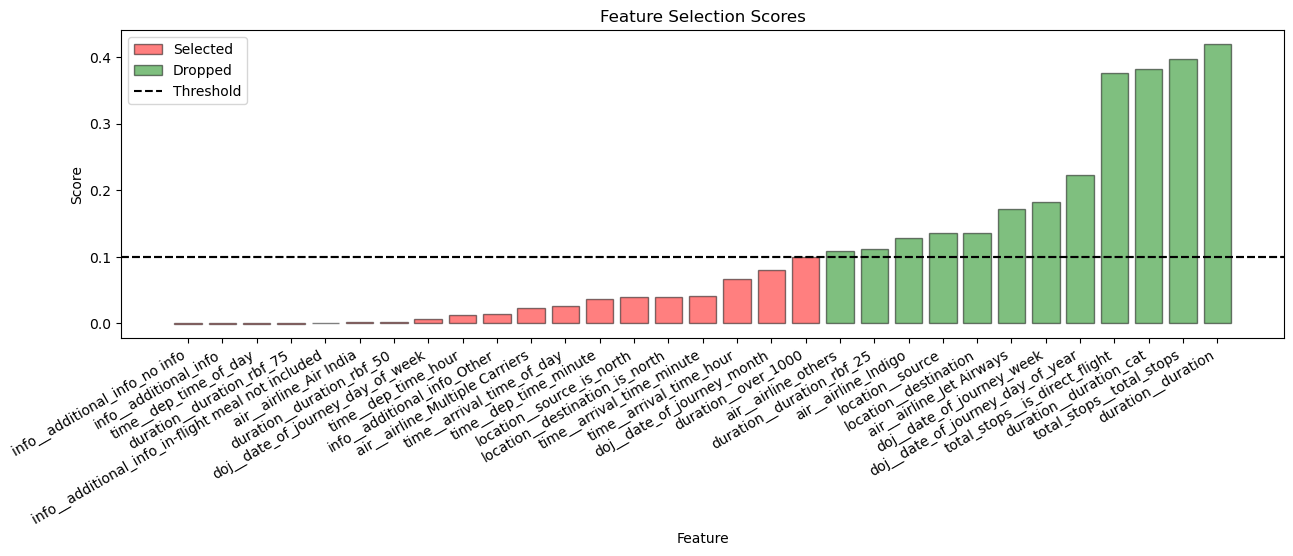

In [554]:

THRESHOLD = 0.1
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]

fig, ax = plt.subplots(figsize=(15, 4))

bars = ax.bar(
    x=range(len(sorted_feat_imp)),
    height=sorted_feat_imp.values(),
    color=colors,
    edgecolor="black",
    alpha=0.5
)

ax.axhline(y=THRESHOLD, color="black", linestyle="--")

ax.set_xticks(ticks=range(len(sorted_feat_imp)), labels=sorted_feat_imp.keys(), rotation=30, ha="right")
ax.set(xlabel="Feature", ylabel="Score", title="Feature Selection Scores")

ax.legend(handles=[bars[0], bars[-1], ax.axhline(y=THRESHOLD, color="black", linestyle="--")],
          labels=["Selected", "Dropped", "Threshold"], loc="upper left")

plt.show()


- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 12 features out of that